In [1]:
import sys
sys.path.insert(0, '../src')

In [2]:
import classify_attention_patterns
import classify_normed_patterns
from argparse import Namespace
from run_glue import load_and_cache_examples, set_seed
from model_bert import BertForSequenceClassification, BertForMaskedLM
from config_bert import BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer
import numpy as np
import torch
import random
from collections import Counter

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=462.48 Hz, eta=0:00:00, total=0:00:00, wall=08:21 CETT
Done!


In [3]:
head_classifier_model, label2id, min_max_size = classify_attention_patterns.load_model("../models/head_classifier/classify_attention_patters.tar")
head_classifier_model = head_classifier_model.eval().cuda()
id2label = {idx:label for label, idx in label2id.items()}

In [4]:
normed_head_classifier_model, normed_label2id, normed_min_max_size = classify_normed_patterns.load_model("../models/head_classifier/classify_normed_patterns.tar")
normed_head_classifier_model = normed_head_classifier_model.eval().cuda()
normed_id2label = {idx:label for label, idx in normed_label2id.items()}

# Fine-tuned model - Super Survivors

In [5]:
set_seed(1337)
for task in ["CoLA", "SST-2", "MRPC", "STS-B", "QQP", "MNLI", "QNLI", "RTE"]:
    attention_counter = Counter()
    normed_attention_counter = Counter()
    for seed in ["seed_1337", "seed_42", "seed_86", "seed_71", "seed_166"]:
        #Load Model
        model_path = f"../models/finetuned/{task}/{seed}/"
        tokenizer = BertTokenizer.from_pretrained(model_path)
        config = BertConfig.from_pretrained(model_path)
        config.output_attentions = True
        transformer_model = BertForSequenceClassification.from_pretrained(model_path,  config=config)
        # Prune
        mask_path = f"../masks/heads_mlps_super/{task}/{seed}/"
        head_mask = np.load(f"{mask_path}/head_mask.npy")
        mlp_mask = np.load(f"{mask_path}/mlp_mask.npy")
        head_mask = torch.from_numpy(head_mask)
        heads_to_prune = {} 
        for layer in range(len(head_mask)):
            heads_to_mask = [h[0] for h in (1 - head_mask[layer].long()).nonzero().tolist()]
            heads_to_prune[layer] = heads_to_mask
        mlps_to_prune = [h[0] for h in (1 - torch.from_numpy(mlp_mask).long()).nonzero().tolist()]

        transformer_model.prune_heads(heads_to_prune)
        transformer_model.prune_mlps(mlps_to_prune)
        transformer_model = transformer_model.eval()
        transformer_model.cuda()
        args = Namespace(data_dir=f"../data/glue/{task}/", local_rank=-1, 
                         model_name_or_path=model_path, 
                         overwrite_cache=False, model_type="bert", max_seq_length=128)
        eval_dataset = load_and_cache_examples(args, task.lower(), tokenizer, evaluate=True)
        eval_sampler = RandomSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=1)
        input_data = None
        attention_head_types = [[] for _ in range(12)]
        normed_attention_head_types = [[] for _ in range(12)]

        k = 0
        for batch in eval_dataloader:
            batch = tuple(t.to("cuda:0") for t in batch)
            n_tokens = batch[1].sum()
            if n_tokens < min_max_size[0]:
                continue
            input_data =  {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            with torch.no_grad():
                _, _, attentions, allalpha_f, attention_mask = transformer_model(**input_data)
                for layer in range(len(attentions)):
                    if attentions[layer] is None:
                        continue

                    num_classifier_tokens = max(n_tokens, min_max_size[0]+20)
                    head_attentions = attentions[layer].transpose(0, 1)

                    head_attentions = head_attentions[:,:,:num_classifier_tokens,:num_classifier_tokens]
                    logits = head_classifier_model(head_attentions)
                    label_ids = torch.argmax(logits, dim=-1)
                    labels = [id2label[int(label_id.item())] for label_id in label_ids]
                    if len(attention_head_types[layer]) == 0:
                        for i in range(len(labels)):
                            attention_head_types[layer].append(Counter())
                    for i, label in enumerate(labels):
                        attention_head_types[layer][i][label] += 1
                    
                    num_classifier_tokens = max(n_tokens, normed_min_max_size[0]+20)
                    normed_alpha_f = allalpha_f[layer].norm(dim=-1)
                    normed_head_attentions = normed_alpha_f.transpose(0, 1)

                    normed_head_attentions = normed_head_attentions[:,:,:num_classifier_tokens,:num_classifier_tokens]
                    logits = normed_head_classifier_model(normed_head_attentions)
                    label_ids = torch.argmax(logits, dim=-1)
                    labels = [normed_id2label[int(label_id.item())] for label_id in label_ids]
                    if len(normed_attention_head_types[layer]) == 0:
                        for i in range(len(labels)):
                            normed_attention_head_types[layer].append(Counter())
                    for i, label in enumerate(labels):
                        normed_attention_head_types[layer][i][label] += 1
                del attentions, allalpha_f
            k += 1
            if k == 100:
                break
        for layer in attention_head_types:
            for head_type_ctr in layer:
                attention_counter += head_type_ctr
        total_counter = Counter()
        for layer in normed_attention_head_types:
            for head_type_ctr in layer:
                normed_attention_counter += head_type_ctr
    print(task)
    print("attention:", {k:v/sum(attention_counter.values()) for k,v in attention_counter.most_common()})
    print("weight normed:", {k:v/sum(normed_attention_counter.values()) for k,v in normed_attention_counter.most_common()})

CoLA
attention: {'mix': 0.4218823529411765, 'other': 0.4046470588235294, 'diagonal': 0.1458235294117647, 'vertical': 0.02123529411764706, 'block': 0.006411764705882353}
weight normed: {'Diagonal': 0.42823529411764705, 'Heterogeneous': 0.3382941176470588, 'Vertical + Diagonal': 0.10252941176470588, 'Block': 0.09682352941176471, 'Vertical': 0.03411764705882353}
SST-2
attention: {'other': 0.3487368421052632, 'diagonal': 0.25705263157894737, 'block': 0.1965263157894737, 'mix': 0.19473684210526315, 'vertical': 0.0029473684210526317}
weight normed: {'Block': 0.36326315789473684, 'Heterogeneous': 0.26063157894736844, 'Diagonal': 0.18894736842105264, 'Vertical + Diagonal': 0.17410526315789474, 'Vertical': 0.013052631578947368}
MRPC
attention: {'vertical': 0.377, 'block': 0.23685714285714285, 'other': 0.18492857142857144, 'diagonal': 0.10107142857142858, 'mix': 0.10014285714285714}
weight normed: {'Heterogeneous': 0.2807857142857143, 'Vertical': 0.25007142857142856, 'Vertical + Diagonal': 0.231

In [ ]:
# SST-2, STS-B, MNLI, RTE

# Finetuned Model - All

In [6]:
set_seed(1337)
for task in ["CoLA", "SST-2", "MRPC", "STS-B", "QQP", "MNLI", "QNLI", "RTE"]:
    attention_counter = Counter()
    normed_attention_counter = Counter()
    for seed in ["seed_1337", "seed_42", "seed_86", "seed_71", "seed_166"]:
        #Load Model
        model_path = f"../models/finetuned/{task}/{seed}/"
        tokenizer = BertTokenizer.from_pretrained(model_path)
        config = BertConfig.from_pretrained(model_path)
        config.output_attentions = True
        transformer_model = BertForSequenceClassification.from_pretrained(model_path,  config=config)
        transformer_model = transformer_model.eval()
        transformer_model.cuda()
        args = Namespace(data_dir=f"../data/glue/{task}/", local_rank=-1, 
                         model_name_or_path=model_path, 
                         overwrite_cache=False, model_type="bert", max_seq_length=128)
        eval_dataset = load_and_cache_examples(args, task.lower(), tokenizer, evaluate=True)
        eval_sampler = RandomSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=1)
        input_data = None
        attention_head_types = [[] for _ in range(12)]
        normed_attention_head_types = [[] for _ in range(12)]

        k = 0
        for batch in eval_dataloader:
            batch = tuple(t.to("cuda:0") for t in batch)
            n_tokens = batch[1].sum()
            if n_tokens < min_max_size[0]:
                continue
            input_data =  {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            with torch.no_grad():
                _, _, attentions, allalpha_f, attention_mask = transformer_model(**input_data)
                for layer in range(len(attentions)):
                    if attentions[layer] is None:
                        continue

                    num_classifier_tokens = max(n_tokens, min_max_size[0]+20)
                    head_attentions = attentions[layer].transpose(0, 1)

                    head_attentions = head_attentions[:,:,:num_classifier_tokens,:num_classifier_tokens]
                    logits = head_classifier_model(head_attentions)
                    label_ids = torch.argmax(logits, dim=-1)
                    labels = [id2label[int(label_id.item())] for label_id in label_ids]
                    if len(attention_head_types[layer]) == 0:
                        for i in range(len(labels)):
                            attention_head_types[layer].append(Counter())
                    for i, label in enumerate(labels):
                        attention_head_types[layer][i][label] += 1
                    
                    num_classifier_tokens = max(n_tokens, normed_min_max_size[0]+20)
                    normed_alpha_f = allalpha_f[layer].norm(dim=-1)
                    normed_head_attentions = normed_alpha_f.transpose(0, 1)

                    normed_head_attentions = normed_head_attentions[:,:,:num_classifier_tokens,:num_classifier_tokens]
                    logits = normed_head_classifier_model(normed_head_attentions)
                    label_ids = torch.argmax(logits, dim=-1)
                    labels = [normed_id2label[int(label_id.item())] for label_id in label_ids]
                    if len(normed_attention_head_types[layer]) == 0:
                        for i in range(len(labels)):
                            normed_attention_head_types[layer].append(Counter())
                    for i, label in enumerate(labels):
                        normed_attention_head_types[layer][i][label] += 1
                del attentions, allalpha_f
            k += 1
            if k == 100:
                break
        for layer in attention_head_types:
            for head_type_ctr in layer:
                attention_counter += head_type_ctr
        total_counter = Counter()
        for layer in normed_attention_head_types:
            for head_type_ctr in layer:
                normed_attention_counter += head_type_ctr
    print(task)
    print("attention:", {k:v/sum(attention_counter.values()) for k,v in attention_counter.most_common()})
    print("weight normed:", {k:v/sum(normed_attention_counter.values()) for k,v in normed_attention_counter.most_common()})

CoLA
attention: {'mix': 0.43254166666666666, 'other': 0.42105555555555557, 'diagonal': 0.07380555555555555, 'vertical': 0.06659722222222222, 'block': 0.006}
weight normed: {'Heterogeneous': 0.4975833333333333, 'Diagonal': 0.26311111111111113, 'Vertical + Diagonal': 0.10448611111111111, 'Block': 0.08558333333333333, 'Vertical': 0.04923611111111111}
SST-2
attention: {'mix': 0.41273611111111114, 'other': 0.2281111111111111, 'diagonal': 0.21891666666666668, 'vertical': 0.08775, 'block': 0.05248611111111111}
weight normed: {'Diagonal': 0.46276388888888886, 'Heterogeneous': 0.31830555555555556, 'Block': 0.11891666666666667, 'Vertical + Diagonal': 0.07868055555555556, 'Vertical': 0.021333333333333333}
MRPC
attention: {'mix': 0.35806944444444444, 'other': 0.23297222222222222, 'diagonal': 0.19951388888888888, 'vertical': 0.14416666666666667, 'block': 0.06527777777777778}
weight normed: {'Diagonal': 0.5124722222222222, 'Heterogeneous': 0.3212083333333333, 'Vertical + Diagonal': 0.099819444444444

# Pre-trained Super Survivors

In [7]:
set_seed(1337)
for task in ["CoLA", "SST-2", "MRPC", "STS-B", "QQP", "MNLI", "QNLI", "RTE"]:
    attention_counter = Counter()
    normed_attention_counter = Counter()
    for seed in ["seed_1337", "seed_42", "seed_86", "seed_71", "seed_166"]:
        #Load Model
        model_path = f"../models/finetuned/{task}/{seed}/"
        tokenizer = BertTokenizer.from_pretrained(model_path)
        config = BertConfig.from_pretrained(model_path)
        config.output_attentions = True
        transformer_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',  config=config)
        # Prune
        mask_path = f"../masks/heads_mlps_super/{task}/{seed}/"
        head_mask = np.load(f"{mask_path}/head_mask.npy")
        mlp_mask = np.load(f"{mask_path}/mlp_mask.npy")
        head_mask = torch.from_numpy(head_mask)
        heads_to_prune = {} 
        for layer in range(len(head_mask)):
            heads_to_mask = [h[0] for h in (1 - head_mask[layer].long()).nonzero().tolist()]
            heads_to_prune[layer] = heads_to_mask
        mlps_to_prune = [h[0] for h in (1 - torch.from_numpy(mlp_mask).long()).nonzero().tolist()]

        transformer_model.prune_heads(heads_to_prune)
        transformer_model.prune_mlps(mlps_to_prune)
        transformer_model = transformer_model.eval()
        transformer_model.cuda()
        args = Namespace(data_dir=f"../data/glue/{task}/", local_rank=-1, 
                         model_name_or_path=model_path, 
                         overwrite_cache=False, model_type="bert", max_seq_length=128)
        eval_dataset = load_and_cache_examples(args, task.lower(), tokenizer, evaluate=True)
        eval_sampler = RandomSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=1)
        input_data = None
        attention_head_types = [[] for _ in range(12)]
        normed_attention_head_types = [[] for _ in range(12)]

        k = 0
        for batch in eval_dataloader:
            batch = tuple(t.to("cuda:0") for t in batch)
            n_tokens = batch[1].sum()
            if n_tokens < min_max_size[0]:
                continue
            input_data =  {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            with torch.no_grad():
                _, _, attentions, allalpha_f, attention_mask = transformer_model(**input_data)
                for layer in range(len(attentions)):
                    if attentions[layer] is None:
                        continue

                    num_classifier_tokens = max(n_tokens, min_max_size[0]+20)
                    head_attentions = attentions[layer].transpose(0, 1)

                    head_attentions = head_attentions[:,:,:num_classifier_tokens,:num_classifier_tokens]
                    logits = head_classifier_model(head_attentions)
                    label_ids = torch.argmax(logits, dim=-1)
                    labels = [id2label[int(label_id.item())] for label_id in label_ids]
                    if len(attention_head_types[layer]) == 0:
                        for i in range(len(labels)):
                            attention_head_types[layer].append(Counter())
                    for i, label in enumerate(labels):
                        attention_head_types[layer][i][label] += 1
                    
                    num_classifier_tokens = max(n_tokens, normed_min_max_size[0]+20)
                    normed_alpha_f = allalpha_f[layer].norm(dim=-1)
                    normed_head_attentions = normed_alpha_f.transpose(0, 1)

                    normed_head_attentions = normed_head_attentions[:,:,:num_classifier_tokens,:num_classifier_tokens]
                    logits = normed_head_classifier_model(normed_head_attentions)
                    label_ids = torch.argmax(logits, dim=-1)
                    labels = [normed_id2label[int(label_id.item())] for label_id in label_ids]
                    if len(normed_attention_head_types[layer]) == 0:
                        for i in range(len(labels)):
                            normed_attention_head_types[layer].append(Counter())
                    for i, label in enumerate(labels):
                        normed_attention_head_types[layer][i][label] += 1
                del attentions, allalpha_f
            k += 1
            if k == 100:
                break
        for layer in attention_head_types:
            for head_type_ctr in layer:
                attention_counter += head_type_ctr
        total_counter = Counter()
        for layer in normed_attention_head_types:
            for head_type_ctr in layer:
                normed_attention_counter += head_type_ctr
    print(task)
    print("attention:", {k:v/sum(attention_counter.values()) for k,v in attention_counter.most_common()})
    print("weight normed:", {k:v/sum(normed_attention_counter.values()) for k,v in normed_attention_counter.most_common()})

CoLA
attention: {'mix': 0.4440588235294118, 'other': 0.3938235294117647, 'diagonal': 0.13805882352941176, 'vertical': 0.01764705882352941, 'block': 0.006411764705882353}
weight normed: {'Diagonal': 0.42164705882352943, 'Heterogeneous': 0.34647058823529414, 'Vertical + Diagonal': 0.10358823529411765, 'Block': 0.09470588235294118, 'Vertical': 0.03358823529411765}
SST-2
attention: {'other': 0.35326315789473683, 'diagonal': 0.2556842105263158, 'mix': 0.19936842105263158, 'block': 0.18852631578947368, 'vertical': 0.003157894736842105}
weight normed: {'Block': 0.3336842105263158, 'Heterogeneous': 0.2963157894736842, 'Vertical + Diagonal': 0.18610526315789475, 'Diagonal': 0.16736842105263158, 'Vertical': 0.016526315789473684}
MRPC
attention: {'vertical': 0.38671428571428573, 'block': 0.2302142857142857, 'other': 0.19514285714285715, 'diagonal': 0.09864285714285714, 'mix': 0.08928571428571429}
weight normed: {'Vertical': 0.2790714285714286, 'Heterogeneous': 0.26971428571428574, 'Vertical + Dia

# Pre-trained All

In [8]:
set_seed(1337)
for task in ["CoLA", "SST-2", "MRPC", "STS-B", "QQP", "MNLI", "QNLI", "RTE"]:
    attention_counter = Counter()
    normed_attention_counter = Counter()
    for seed in ["seed_1337", "seed_42", "seed_86", "seed_71", "seed_166"]:
        #Load Model
        model_path = f"../models/finetuned/{task}/{seed}/"
        tokenizer = BertTokenizer.from_pretrained(model_path)
        config = BertConfig.from_pretrained(model_path)
        config.output_attentions = True
        transformer_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',  config=config)
        transformer_model = transformer_model.eval()
        
        transformer_model.cuda()
        args = Namespace(data_dir=f"../data/glue/{task}/", local_rank=-1, 
                         model_name_or_path=model_path, 
                         overwrite_cache=False, model_type="bert", max_seq_length=128)
        eval_dataset = load_and_cache_examples(args, task.lower(), tokenizer, evaluate=True)
        eval_sampler = RandomSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=1)
        input_data = None
        attention_head_types = [[] for _ in range(12)]
        normed_attention_head_types = [[] for _ in range(12)]

        k = 0
        for batch in eval_dataloader:
            batch = tuple(t.to("cuda:0") for t in batch)
            n_tokens = batch[1].sum()
            if n_tokens < min_max_size[0]:
                continue
            input_data =  {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            with torch.no_grad():
                _, _, attentions, allalpha_f, attention_mask = transformer_model(**input_data)
                for layer in range(len(attentions)):
                    if attentions[layer] is None:
                        continue

                    num_classifier_tokens = max(n_tokens, min_max_size[0]+20)
                    head_attentions = attentions[layer].transpose(0, 1)

                    head_attentions = head_attentions[:,:,:num_classifier_tokens,:num_classifier_tokens]
                    logits = head_classifier_model(head_attentions)
                    label_ids = torch.argmax(logits, dim=-1)
                    labels = [id2label[int(label_id.item())] for label_id in label_ids]
                    if len(attention_head_types[layer]) == 0:
                        for i in range(len(labels)):
                            attention_head_types[layer].append(Counter())
                    for i, label in enumerate(labels):
                        attention_head_types[layer][i][label] += 1
                    
                    num_classifier_tokens = max(n_tokens, normed_min_max_size[0]+20)
                    normed_alpha_f = allalpha_f[layer].norm(dim=-1)
                    normed_head_attentions = normed_alpha_f.transpose(0, 1)

                    normed_head_attentions = normed_head_attentions[:,:,:num_classifier_tokens,:num_classifier_tokens]
                    logits = normed_head_classifier_model(normed_head_attentions)
                    label_ids = torch.argmax(logits, dim=-1)
                    labels = [normed_id2label[int(label_id.item())] for label_id in label_ids]
                    if len(normed_attention_head_types[layer]) == 0:
                        for i in range(len(labels)):
                            normed_attention_head_types[layer].append(Counter())
                    for i, label in enumerate(labels):
                        normed_attention_head_types[layer][i][label] += 1
                del attentions, allalpha_f
            k += 1
            if k == 100:
                break
        for layer in attention_head_types:
            for head_type_ctr in layer:
                attention_counter += head_type_ctr
        total_counter = Counter()
        for layer in normed_attention_head_types:
            for head_type_ctr in layer:
                normed_attention_counter += head_type_ctr
    print(task)
    print("attention:", {k:v/sum(attention_counter.values()) for k,v in attention_counter.most_common()})
    print("weight normed:", {k:v/sum(normed_attention_counter.values()) for k,v in normed_attention_counter.most_common()})

CoLA
attention: {'mix': 0.43969444444444444, 'other': 0.41041666666666665, 'vertical': 0.07502777777777778, 'diagonal': 0.06875, 'block': 0.006111111111111111}
weight normed: {'Heterogeneous': 0.5134583333333333, 'Diagonal': 0.23484722222222223, 'Vertical + Diagonal': 0.11059722222222222, 'Block': 0.07826388888888888, 'Vertical': 0.06283333333333334}
SST-2
attention: {'mix': 0.40734722222222225, 'other': 0.225, 'diagonal': 0.20219444444444445, 'vertical': 0.11197222222222222, 'block': 0.05348611111111111}
weight normed: {'Diagonal': 0.424625, 'Heterogeneous': 0.33469444444444446, 'Block': 0.10854166666666666, 'Vertical + Diagonal': 0.0976111111111111, 'Vertical': 0.034527777777777775}
MRPC
attention: {'mix': 0.358625, 'other': 0.2555, 'vertical': 0.16709722222222223, 'diagonal': 0.16061111111111112, 'block': 0.058166666666666665}
weight normed: {'Diagonal': 0.4820833333333333, 'Heterogeneous': 0.32166666666666666, 'Vertical + Diagonal': 0.13972222222222222, 'Block': 0.04177777777777777

# Correlation coefficient

In [5]:

heterogeneous = []
survivors = []

set_seed(1337)
for task in ["CoLA", "SST-2", "MRPC", "STS-B", "QQP", "MNLI", "QNLI", "RTE"]:
    attention_counter = Counter()
    normed_attention_counter = Counter()
    for seed in ["seed_1337", "seed_42", "seed_86", "seed_71", "seed_166"]:
        #Load Model
        model_path = f"../models/finetuned/{task}/{seed}/"
        tokenizer = BertTokenizer.from_pretrained(model_path)
        config = BertConfig.from_pretrained(model_path)
        config.output_attentions = True
        transformer_model = BertForSequenceClassification.from_pretrained(model_path,  config=config)
        mask_path = f"../masks/heads_mlps_super/{task}/{seed}/"
        head_mask = np.load(f"{mask_path}/head_mask.npy")
        mlp_mask = np.load(f"{mask_path}/mlp_mask.npy")
        head_mask = torch.from_numpy(head_mask)
        heads_to_prune = {} 
        for layer in range(len(head_mask)):
            heads_to_mask = [h[0] for h in (1 - head_mask[layer].long()).nonzero().tolist()]
            heads_to_prune[layer] = heads_to_mask
        mlps_to_prune = [h[0] for h in (1 - torch.from_numpy(mlp_mask).long()).nonzero().tolist()]
        
        
        transformer_model = transformer_model.eval()
        transformer_model.cuda()
        args = Namespace(data_dir=f"../data/glue/{task}/", local_rank=-1, 
                         model_name_or_path=model_path, 
                         overwrite_cache=False, model_type="bert", max_seq_length=128)
        eval_dataset = load_and_cache_examples(args, task.lower(), tokenizer, evaluate=True)
        eval_sampler = RandomSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=1)
        input_data = None
        attention_head_types = [[] for _ in range(12)]
        normed_attention_head_types = [[] for _ in range(12)]

        k = 0
        for batch in eval_dataloader:
            batch = tuple(t.to("cuda:0") for t in batch)
            n_tokens = batch[1].sum()
            if n_tokens < min_max_size[0]:
                continue
            input_data =  {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            with torch.no_grad():
                _, _, attentions, allalpha_f, attention_mask = transformer_model(**input_data)
                for layer in range(len(attentions)):
                    if attentions[layer] is None:
                        continue
                    
                    num_classifier_tokens = max(n_tokens, normed_min_max_size[0]+20)
                    normed_alpha_f = allalpha_f[layer].norm(dim=-1)
                    normed_head_attentions = normed_alpha_f.transpose(0, 1)

                    normed_head_attentions = normed_head_attentions[:,:,:num_classifier_tokens,:num_classifier_tokens]
                    logits = normed_head_classifier_model(normed_head_attentions)
                    label_ids = torch.argmax(logits, dim=-1)
                    labels = [normed_id2label[int(label_id.item())] for label_id in label_ids]
                    
                    for head, label in enumerate(labels):
                        
                        is_heterogeneous = label == 'Heterogeneous'
                        is_survivor = head not in heads_to_prune[layer]
                        if is_heterogeneous:
                            heterogeneous.append(1.)
                        else:
                            heterogeneous.append(0.)
                        if is_survivor:
                            survivors.append(1.)
                        else:
                            survivors.append(0.)
                del attentions, allalpha_f
            k += 1
            if k == 100:
                break

In [6]:
from scipy.stats import pearsonr

In [7]:
pearsonr(heterogeneous, survivors)

(0.0022907000419617545, 0.08211965091231407)

# Attention Patterns

In [48]:
patterns = {
    "CoLA": {
      "attention": {'mix': 0.4218823529411765, 'other': 0.4046470588235294, 'diagonal': 0.1458235294117647, 'vertical': 0.02123529411764706, 'block': 0.006411764705882353},
      "weight normed": {'Diagonal': 0.42823529411764705, 'Heterogeneous': 0.3382941176470588, 'Vertical + Diagonal': 0.10252941176470588, 'Block': 0.09682352941176471, 'Vertical': 0.03411764705882353}
    },
    "SST-2": {
      "attention": {'other': 0.3487368421052632, 'diagonal': 0.25705263157894737, 'block': 0.1965263157894737, 'mix': 0.19473684210526315, 'vertical': 0.0029473684210526317},
      "weight normed": {'Block': 0.36326315789473684, 'Heterogeneous': 0.26063157894736844, 'Diagonal': 0.18894736842105264, 'Vertical + Diagonal': 0.17410526315789474, 'Vertical': 0.013052631578947368},
    },
    "MRPC": {
      "attention": {'vertical': 0.377, 'block': 0.23685714285714285, 'other': 0.18492857142857144, 'diagonal': 0.10107142857142858, 'mix': 0.10014285714285714},
      "weight normed": {'Heterogeneous': 0.2807857142857143, 'Vertical': 0.25007142857142856, 'Vertical + Diagonal': 0.23157142857142857, 'Diagonal': 0.18985714285714286, 'Block': 0.047714285714285716}
    },
    "STS-B": {
      "attention": {'other': 0.6768333333333333, 'block': 0.13475, 'diagonal': 0.1115, 'mix': 0.059583333333333335, 'vertical': 0.017333333333333333},
      "weight normed": {'Heterogeneous': 0.438, 'Block': 0.28391666666666665, 'Diagonal': 0.1285, 'Vertical + Diagonal': 0.12166666666666667, 'Vertical': 0.027916666666666666}
    },
    "QQP": {
      "attention": {'other': 0.5302608695652173, 'mix': 0.14478260869565218, 'diagonal': 0.1376521739130435, 'vertical': 0.13460869565217393, 'block': 0.052695652173913046},
      "weight normed":  {'Vertical': 0.34956521739130436, 'Vertical + Diagonal': 0.1988695652173913, 'Heterogeneous': 0.198, 'Diagonal': 0.16643478260869565, 'Block': 0.08713043478260869}
    },
    "MNLI": {
      "attention": {'other': 0.354, 'diagonal': 0.2806, 'block': 0.2482, 'mix': 0.0948, 'vertical': 0.0224},
      "weight normed": {'Diagonal': 0.3262, 'Block': 0.2945, 'Heterogeneous': 0.2137, 'Vertical + Diagonal': 0.1589, 'Vertical': 0.0067}
    },
    "QNLI": {
      "attention": {'other': 0.5126451612903226, 'diagonal': 0.2372258064516129, 'block': 0.16548387096774195, 'mix': 0.05987096774193548, 'vertical': 0.024774193548387096},
      "weight normed": {'Diagonal': 0.36316129032258065, 'Heterogeneous': 0.2718709677419355, 'Vertical + Diagonal': 0.16612903225806452, 'Block': 0.10541935483870968, 'Vertical': 0.09341935483870968}
    },
    "RTE": {
      "attention": {'block': 0.5658181818181818, 'diagonal': 0.158, 'other': 0.15454545454545454, 'mix': 0.09945454545454545, 'vertical': 0.02218181818181818},
      "weight normed": {'Heterogeneous': 0.46036363636363636, 'Vertical + Diagonal': 0.22927272727272727, 'Block': 0.1698181818181818, 'Diagonal': 0.1390909090909091, 'Vertical': 0.0014545454545454545}  
    },

}

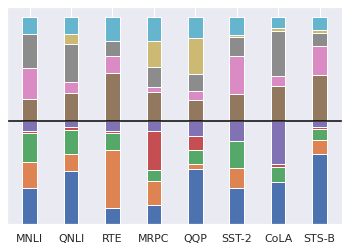

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


tasks = ['MNLI', 'QNLI', 'RTE', 'MRPC', 'QQP', 'SST-2', 'CoLA', 'STS-B']

heterogeneous = np.array([patterns[task]['attention']['other'] * 100 for task in tasks])
block =  np.array([patterns[task]['attention']['block'] * 100 for task in tasks])
diagonal = np.array([patterns[task]['attention']['diagonal'] * 100 for task in tasks])
vertical = np.array([patterns[task]['attention']['vertical'] * 100 for task in tasks])
vertical_diagonal = np.array([patterns[task]['attention']['mix'] * 100 for task in tasks])

wn_hetero = np.array([patterns[task]['weight normed']['Heterogeneous'] * 100 for task in tasks])
wn_block =  np.array([patterns[task]['weight normed']['Block'] * 100 for task in tasks])
wn_diagonal = np.array([patterns[task]['weight normed']['Diagonal'] * 100 for task in tasks])
wn_vertical = np.array([patterns[task]['weight normed']['Vertical'] * 100 for task in tasks])
wn_vertical_diagonal = np.array([patterns[task]['weight normed']['Vertical + Diagonal'] * 100 for task in tasks])
N = len(heterogeneous)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


stuff_to_stack = [heterogeneous, block, diagonal, vertical, vertical_diagonal, wn_hetero, wn_block, wn_diagonal, wn_vertical, wn_vertical_diagonal]
ps = []
summed = None
for i, stuff in enumerate(stuff_to_stack):
    p = plt.bar(ind, stuff, width, bottom=summed)
    ps.append(p)
    if summed is None:
        summed = stuff
    else:
        summed += stuff
    
plt.xticks(ind, tasks)
plt.yticks([], [])
plt.axhline(100, color='black')
# legend = ["heterogeneous", "block", "diagonal", "vertical", "vertical+diagonal"]
# plt.legend((ps[0][0], ps[1][0], ps[2][0], ps[3][0], ps[4][0]), ('heterogeneous', "block", "diagonal", "vertical", "vertical+diagonal"))
#plt.legend((ps[5][0], ps[6][0], ps[7][0], ps[8][0], ps[9][0]), ('heterogeneous', "block", "diagonal", "vertical", "vertical+diagonal"))

plt.show()

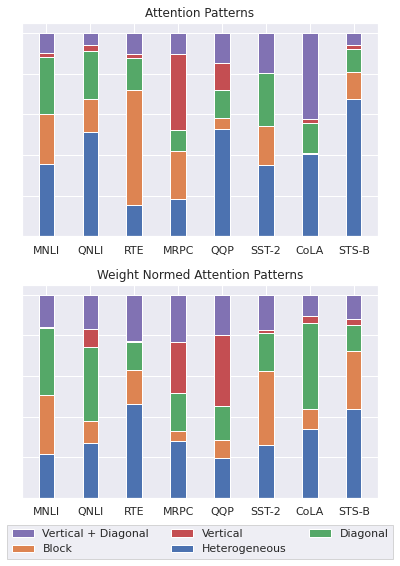

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set()
def flip(items, ncol):
    return list(itertools.chain(*[items[i::ncol] for i in range(ncol)]))


tasks = ['MNLI', 'QNLI', 'RTE', 'MRPC', 'QQP', 'SST-2', 'CoLA', 'STS-B']

heterogeneous = np.array([patterns[task]['attention']['other'] * 100 for task in tasks])
block =  np.array([patterns[task]['attention']['block'] * 100 for task in tasks])
diagonal = np.array([patterns[task]['attention']['diagonal'] * 100 for task in tasks])
vertical = np.array([patterns[task]['attention']['vertical'] * 100 for task in tasks])
vertical_diagonal = np.array([patterns[task]['attention']['mix'] * 100 for task in tasks])

wn_hetero = np.array([patterns[task]['weight normed']['Heterogeneous'] * 100 for task in tasks])
wn_block =  np.array([patterns[task]['weight normed']['Block'] * 100 for task in tasks])
wn_diagonal = np.array([patterns[task]['weight normed']['Diagonal'] * 100 for task in tasks])
wn_vertical = np.array([patterns[task]['weight normed']['Vertical'] * 100 for task in tasks])
wn_vertical_diagonal = np.array([patterns[task]['weight normed']['Vertical + Diagonal'] * 100 for task in tasks])
N = len(heterogeneous)

ind = np.arange(len(tasks))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 8))
ax1.set_title("Attention Patterns")
stuff_to_stack = [heterogeneous, block, diagonal, vertical, vertical_diagonal]
ps_1s = []
summed = None
for i, stuff in enumerate(stuff_to_stack):
    p = ax1.bar(ind, stuff, width, bottom=summed)
    ps_1s.append(p)
    if summed is None:
        summed = stuff
    else:
        summed += stuff
ax1.set_xticks(ind)
ax1.set_xticklabels(tasks)
ax1.set_yticklabels([], [])

ax2.set_title("Weight Normed Attention Patterns")
stuff_to_stack_2 = [wn_hetero, wn_block, wn_diagonal, wn_vertical, wn_vertical_diagonal]
ps_2s = []
summed = None
for i, stuff in enumerate(stuff_to_stack_2):
    p = ax2.bar(ind, stuff, width, bottom=summed)
    ps_2s.append(p)
    if summed is None:
        summed = stuff
    else:
        summed += stuff
ax2.set_xticks(ind)
ax2.set_xticklabels(tasks)

ax2.set_yticklabels([], [])
#fig.subplots_adjust(bottom=0.3, wspace=0.33)
ax2.legend(flip(list(reversed(ps_2s)), 3), flip(list(reversed(["Heterogeneous", "Block", "Diagonal", "Vertical", "Vertical + Diagonal"])), 3), loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=False, shadow=False, ncol=3)

fig.tight_layout()
fig.savefig("common_components/patterns.pdf")
plt.show()

In [108]:
 flip(["Heterogeneous", "Block", "Diagonal", "Vertical", "Vertical + Diagonal"], 3)

['Heterogeneous', 'Vertical', 'Block', 'Vertical + Diagonal', 'Diagonal']

8